In [2]:
from tqdm import tqdm
import nltk
import re
import contractions
import spacy
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
nltk.download('stopwords')
nltk.download('wordnet')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import KFold, cross_val_score
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import pandas as pd
import itertools



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\daffa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\daffa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
def text_preprocess(text, options={}):
    
    exclude_words = ["above", "after", "before", "between", "both", "but", "by", "during", "each", "for", "from",
                    "further", "if", "in", "into", "more", "most", "not", "now", "off", "on", "once", "only", "or",
                    "other", "out", "over", "so", "some", "such", "than", "that", "then", "there", "these", "under",
                    "untill", "when", "where", "which", "while", "will", "with", "because"]
    # Lowercase text
    text = text.lower()
    
    # Remove Contraction
    text = contractions.fix(text)
    
    # Remove Punction
    text = re.sub(r'[^\w\s]', ' ', text)
    
    # Tokenize text
    tokens = nltk.word_tokenize(text)
    
    # Remove stopwords
    if options.get("remove_stopwords", True):
        stop_words = set(stopwords.words('english'))

        # Exclude specific conditional words
        if options.get("exclude_conditional_stopwords", True):
            stop_words = set([word for word in stop_words if word not in exclude_words])
        
        tokens = [token for token in tokens if token not in stop_words]
    
    # Lemmatize text
    if options.get("lemmatize", True):
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # Stem text
    if options.get("stem", True):
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(token) for token in tokens]
    
    # Join tokens back into text string
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text

In [4]:
def dataset_preprocess(datasets, options={}):
    data_preprocess = datasets
    for data in data_preprocess:
        data["text"]= text_preprocess(data["text"], options)
    
    return data_preprocess

In [5]:
import json

datasets = []
with open("./annotated/beres.jsonl", "r") as input_file:
    for line in input_file:
        # Load the line as a JSON object
        data = json.loads(line)

        text, label = data["text"], data["accept"]

        if len(label) > 0:
            datasets.append({
                "text": text,
                "label": label[0]
            })


In [8]:
options = {
    'remove_stopwords': True, 
    'lemmatize': True, 
    'stem': True,
    'exclude_conditional_stopwords': True
}

option_values = itertools.product([True, False], repeat=len(options))

list_combination = []

for values in option_values:
    # Create a new options dictionary with the current combination of values
    current_options = {key: value for key, value in zip(options.keys(), values)}


    preprocess = dataset_preprocess(datasets, current_options)

    filename = ""
    for key, value in current_options.items():
        filename += f"{str(value)[0]} "

    list_combination.append({
        "combination": filename,
        "dataset": preprocess
    })
    
    
    

In [11]:
df = pd.DataFrame(datasets)

label_counts = df['label'].value_counts()

print(label_counts)

POSTCONDITION    355
BOTH             121
PRECONDITION       5
Name: label, dtype: int64


In [142]:

from sklearn.pipeline import Pipeline


accuracy = []
for item in list_combination:

    # Load data into a pandas DataFrame
    data_tranform = pd.DataFrame(item["dataset"])

    # Feature extraction: convert text to a bag of words representation
    count_vect = CountVectorizer()
    X_counts = count_vect.fit_transform(data_tranform['text'])

    # Define the classifiers
    svc = SVC()
    nb = MultinomialNB()
    rf = RandomForestClassifier(n_estimators=10)
    dt = DecisionTreeClassifier()
    lr = LogisticRegression()

    # Define the KFold cross-validation with 5 folds
    kf = KFold(n_splits=5, shuffle=True, random_state=30)

    # Create a pipeline with a Naive Bayes classifier
    text_clf = Pipeline([('vect', CountVectorizer()), ('clf', MultinomialNB())])


    data_accuracy = {
        "combination": item["combination"],
        "model": []
    }
    # Run cross-validation on each classifier and print the mean accuracy score
    for clf, name in [(svc, 'SVC'), (nb, 'Naive Bayes'), (rf, 'Random Forest'), (dt, 'Decision Tree'), (lr, 'Logistic Regression')]:
        scores = cross_val_score(clf, X_counts, data_tranform["label"], cv=kf)

        data_accuracy["model"].append({
            "name": name,
            "score":scores.mean()
        })

    accuracy.append(data_accuracy)



In [146]:
accuracy

[{'combination': 'T T T T ',
  'model': [{'name': 'SVC', 'score': 0.7380154639175257},
   {'name': 'Naive Bayes', 'score': 0.7171176975945017},
   {'name': 'Random Forest', 'score': 0.7213487972508591},
   {'name': 'Decision Tree', 'score': 0.6943943298969072},
   {'name': 'Logistic Regression', 'score': 0.744286941580756}]},
 {'combination': 'T T T F ',
  'model': [{'name': 'SVC', 'score': 0.7380154639175257},
   {'name': 'Naive Bayes', 'score': 0.7171176975945017},
   {'name': 'Random Forest', 'score': 0.7359321305841924},
   {'name': 'Decision Tree', 'score': 0.6798969072164949},
   {'name': 'Logistic Regression', 'score': 0.744286941580756}]},
 {'combination': 'T T F T ',
  'model': [{'name': 'SVC', 'score': 0.7380154639175257},
   {'name': 'Naive Bayes', 'score': 0.7171176975945017},
   {'name': 'Random Forest', 'score': 0.7567654639175256},
   {'name': 'Decision Tree', 'score': 0.6861683848797251},
   {'name': 'Logistic Regression', 'score': 0.744286941580756}]},
 {'combination':

In [143]:
import matplotlib.pyplot as plt
import numpy as np

In [144]:
best_score = 0
best_combination = ""
best_model = ""

for combination in accuracy:
    for model in combination["model"]:
        if model["score"] > best_score:
            best_score = model["score"]
            best_combination = combination["combination"]
            best_model = model["name"]
            
print(f"The best combination is {best_combination} with the {best_model} model scoring {best_score}")

The best combination is T T F T  with the Random Forest model scoring 0.7567654639175256


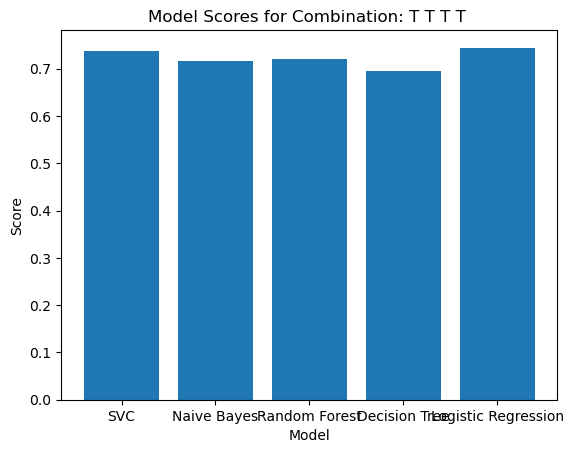

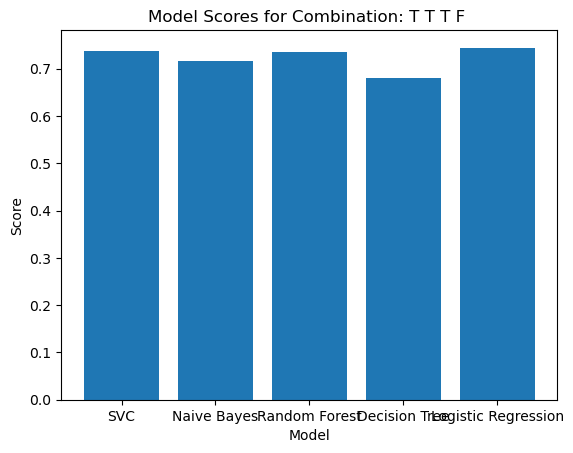

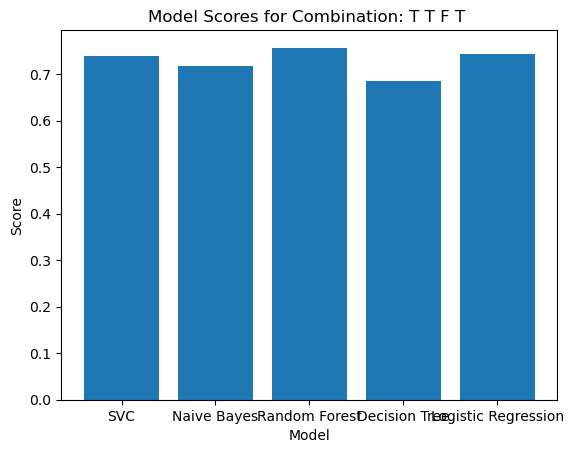

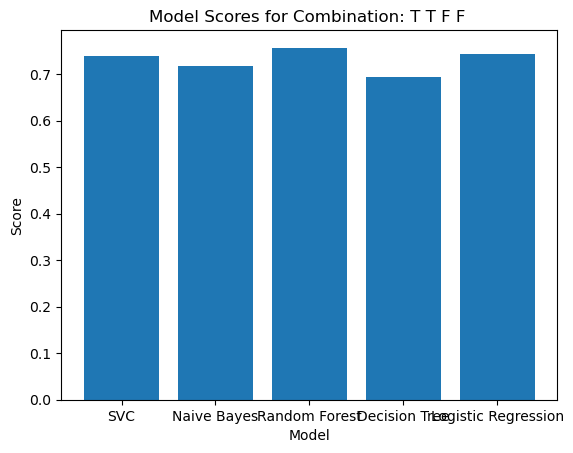

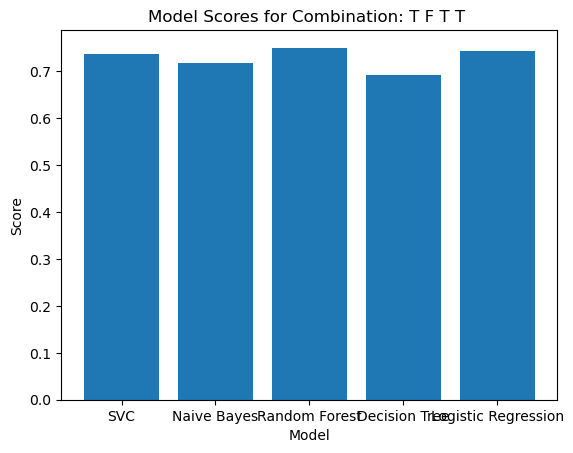

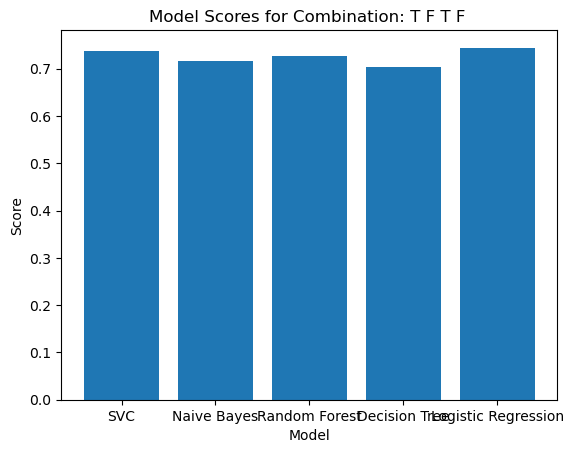

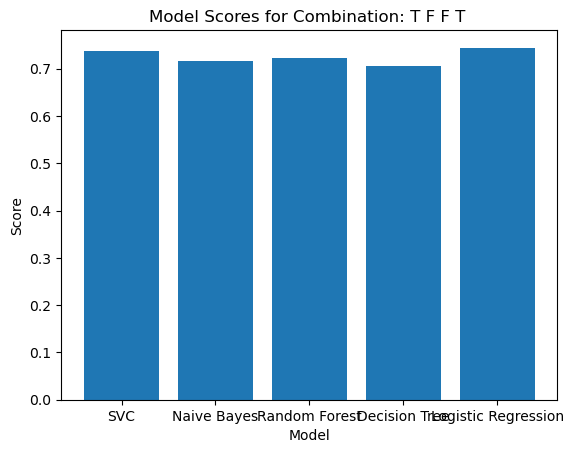

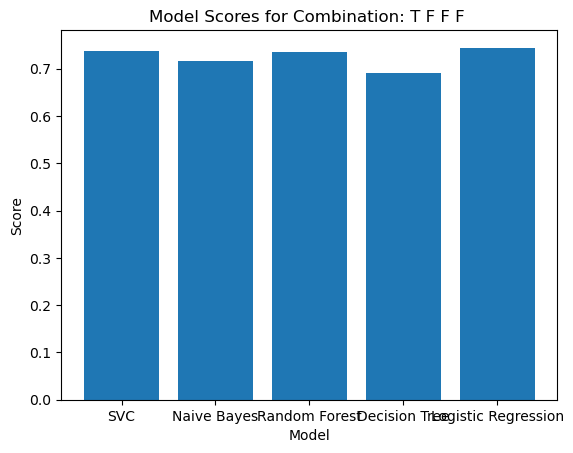

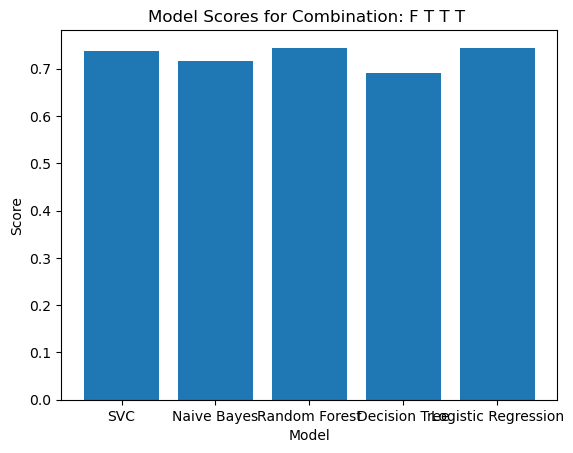

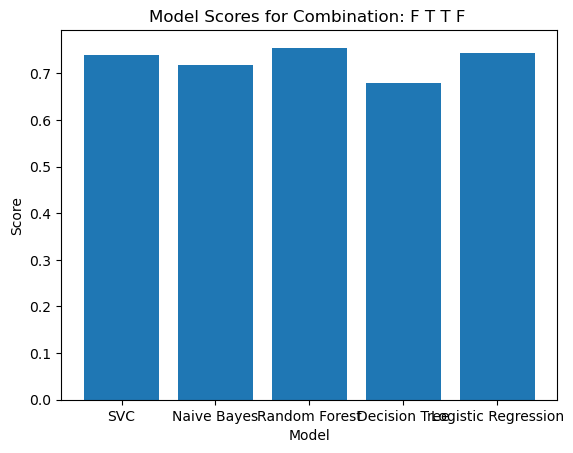

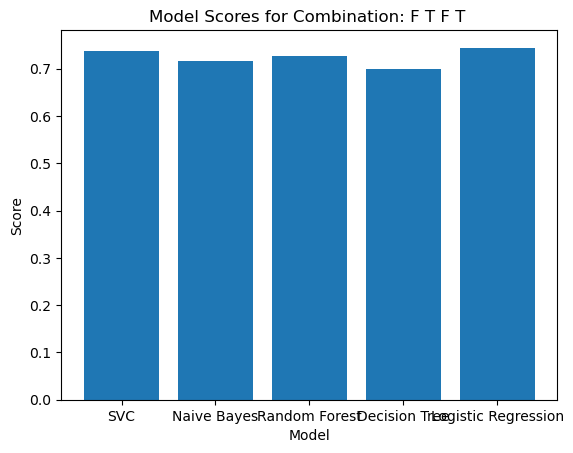

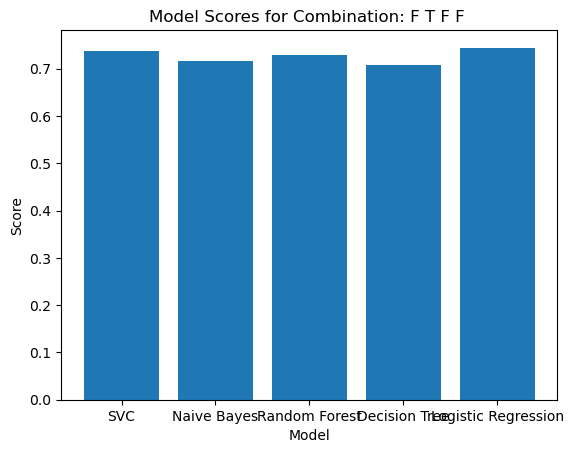

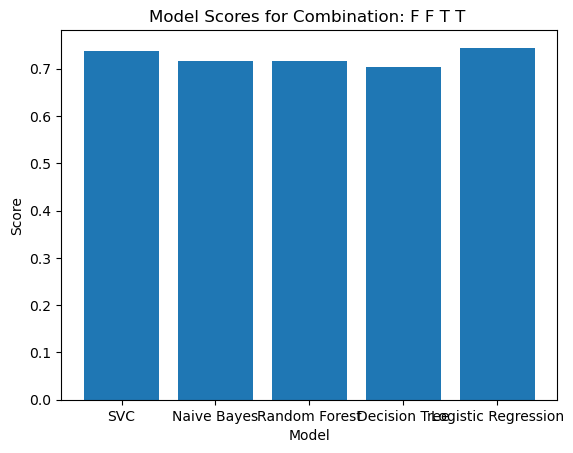

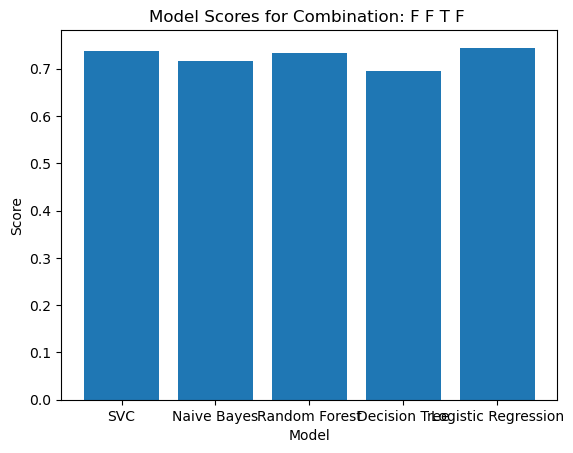

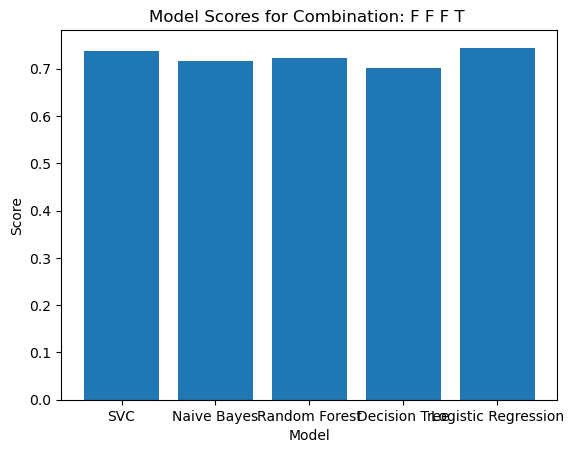

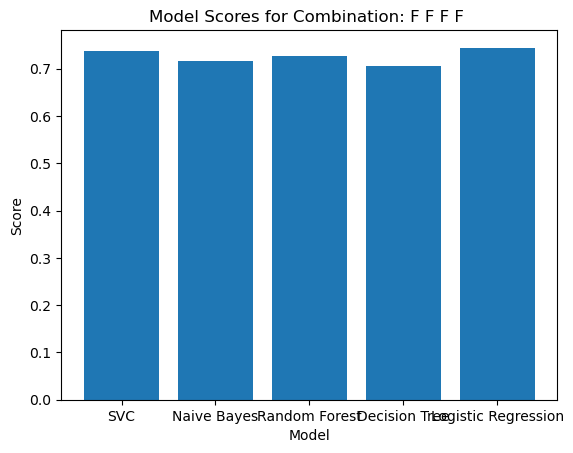

In [145]:
for data in accuracy:
    combination = data['combination']
    model_names = [model['name'] for model in data['model']]
    model_scores = [model['score'] for model in data['model']]
    
    plt.bar(model_names, model_scores)
    plt.title(f'Model Scores for Combination: {combination}')
    plt.xlabel('Model')
    plt.ylabel('Score')

    plt.show()